# 중고차 가격 예측 경진대회 두 번째 베이스라인

이번 대회는 중고차 시장 데이터를 이용하여 중고차 가격 예측을 예측하는 대회입니다.

EDA를 통한 전처리 과정을 모델에 적용해보고,

모델에서 앙상블 과정을 통해서 모델의 성능을 더욱 높여보겠습니다.


## 데이터 불러오기

In [23]:
import pandas as pd ## pandas 라이브러리를 가져오기 위하여 import를 해줍니다.

# csv 형식으로 된 데이터 파일을 읽어옵니다.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'train data set은 {train.shape[1]} 개의 feature를 가진 {train.shape[0]} 개의 데이터 샘플로 이루어져 있습니다.')

# 데이터의 최상단 5 줄을 표시합니다.
train.head()

train data set은 11 개의 feature를 가진 1015 개의 데이터 샘플로 이루어져 있습니다.


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


트레인과 테스트 데이터 모양 행과 열을 살펴보면 다음과 같습니다.

In [24]:
print(train.shape, test.shape)

(1015, 11) (436, 10)


## 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

이번 데이터에 결측치가 있나 확인해볼까요?

In [25]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


중고차 가격 예측 하기 위한 데이터는 결측치가 존재하지 않은 것으로 확인되었습니다.

## 데이터 전처리

EDA과정에서 인사이트를 발굴하여 적용했던 전처리 과정을 살펴보곘습니다.

### 오탈자 처리

In [26]:
train[train['year'] < 1900]

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
415,415,Mercedes-Benz ATEGO,403461,Lagos,Locally used,4-cylinder(I4),manual,diesel,white,1218,6015000
827,827,Mercedes-Benz/52,510053,Lagos,Locally used,6-cylinder(V6),manual,diesel,white,1217,75015000


위의 year에서 1218, 1217 데이터가 존재합니다.

이는 오기입된 데이터라고 판단될 수 있으므로 제거를 해줍시다.

In [27]:
train = train[train['year'] > 1900]
train = train.drop('id', axis = 1).reset_index().drop('index', axis = 1).reset_index().rename({'index':'id'}, axis = 'columns')
train.shape

(1013, 11)

### 파생변수 생성

title 컬럼을 살펴보겠습니다.

In [28]:
train['title'].value_counts()[:20]

Toyota Camry            129
Toyota Corolla          108
Toyota Highlander        50
Toyota Sienna            49
Toyota RAV 4             40
Honda Accord             38
Lexus RX 350             33
Lexus ES 350             24
Toyota Venza             16
Lexus GX 460             16
Honda Pilot              15
Lexus LX 570             14
Mercedes-Benz ML 350     13
Toyota Avalon            13
Mercedes-Benz GL 450     12
Toyota Matrix            12
Toyota Tacoma            12
Ford Explorer            12
Mercedes-Benz E 350      12
Toyota 4-Runner          12
Name: title, dtype: int64

도요타, 혼다, 렉서스, 벤츠 등 title 변수를 통하여 상위 변수로 Brand 변수도 생성해 낼 수 있을 것 같군요!
브랜드 별 카테고리 변수도 추가해주면 분석에 용이할 것 같습니다.

<br>

브랜드는 띄어쓰기 기준으로 첫번째 단어에 위치해 있으므로 첫번째 단어를 플래그로 기준으로 나누어 보도록 하겠습니다.

In [29]:
train['brand'] = train['title'].apply(lambda x : x.split(" ")[0])
train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000,Toyota
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000,Toyota
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000,Land
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000,Lexus
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000,Toyota


In [30]:
print('title의 unique 카테고리 개수 : ', len(train['title'].value_counts()))
print('brand의 unique 카테고리 개수 : ', len(train['brand'].value_counts()))

title의 unique 카테고리 개수 :  201
brand의 unique 카테고리 개수 :  41


201개 카테고리에서 41개 카테고리로 줄어든 새로운 brand 파생변수를 생성했습니다.

많이 줄어들었지만 그래도 여전히 카테고리가 많긴 하군요!

### 데이터 정제

paint 컬럼을 살펴보겠습니다.

In [31]:
train['paint'].value_counts()[:20]

Black        292
White        115
Silver       103
Grey          84
Blue          70
Red           53
Dark Grey     47
Gold          37
white         24
Green         18
Gray          17
Brown         16
Black         15
Dark Blue     14
Wine           8
Silver         5
Sliver         5
blue           5
red            5
Grey           3
Name: paint, dtype: int64

'Black', 'Black '

'Red', 'red'

띄어쓰기, 대소문자가 고르지 못한 단어들이 보이는군요.

이럴 경우 정규표현식을 이용하여 통일성을 맞춰줍시다.

In [32]:
import re

def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>\<]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','',review)#숫자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        #review = re.sub(r'l', '', review)
        corpus.append(review)

    return corpus


In [33]:
print('정제 전 brand의 unique 카테고리 개수 : ', len(train['paint'].unique()))

temp = clean_text(train['paint']) #메소드 적용
train['paint'] = temp

print('정제 후 brand의 unique 카테고리 개수 : ', len(train['paint'].unique()))

정제 전 brand의 unique 카테고리 개수 :  76
정제 후 brand의 unique 카테고리 개수 :  51


76개에서 51개의 카테고리로 줄어들었습니다.
그래도 여전히 많군요.

다시한번 카테고리를 봐 봅시다.

In [34]:
train['paint'].value_counts()[:20]

black        310
white        142
silver       109
grey          87
blue          78
red           58
dark grey     48
gold          41
green         20
gray          18
dark blue     17
brown         16
wine           9
sliver         5
dark ash       4
cream          4
ash            3
purple         3
yellow         3
whiteblue      2
Name: paint, dtype: int64

'Silver, 'Sliver'

'grey', 'dark grey'

등 오타가 있고,

색상의 명도 및 채도 차이가 있군요.

이럴 경우에 오타를 수정해주고 대표할 수 있는 색상으로 글자를 바꿔줍시다!

In [35]:
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
train['paint'] = train['paint'] = train['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

In [36]:
train['paint'].value_counts()

black     312
grey      159
white     146
silver    117
blue      105
red        60
gold       42
green      21
brown      17
wine       10
ash         8
cream       4
purple      3
yellow      3
milk        2
maroon      2
beige       1
orange      1
Name: paint, dtype: int64

In [37]:
print('paint의 unique 카테고리 개수 : ', len(train['paint'].value_counts()))

paint의 unique 카테고리 개수 :  18


### 라벨 인코딩

그럼, 베이스라인 1에서 object형 데이터를 처리해준 것 처럼,

**'Label Encoding'** 을 통해서 문자형 카테고리형 속성은 모두 숫자 값으로 변환/인코딩 해보겠습니다.

In [38]:
#라벨인코딩을 하기 위함 dictionary map 생성 함수
def make_label_map(dataframe):
    label_maps = {}
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            label_map = {'unknown':0}
            for i, key in enumerate(dataframe[col].unique()):
                label_map[key] = i+1  #새로 등장하는 유니크 값들에 대해 1부터 1씩 증가시켜 키값을 부여해줍니다.
            label_maps[col] = label_map
    print(label_maps)
    return label_maps

# 각 범주형 변수에 인코딩 값을 부여하는 함수
def label_encoder(dataframe, label_map):
    for col in dataframe.columns:
        if dataframe[col].dtype=='object':
            dataframe[col] = dataframe[col].map(label_map[col])
            dataframe[col] = dataframe[col].fillna(label_map[col]['unknown']) #혹시 모를 결측값은 unknown의 값(0)으로 채워줍니다.
    return dataframe

le = make_label_map(train)
train = label_encoder(train, le)
train.head()

{'title': {'unknown': 0, 'Toyota RAV 4': 1, 'Toyota Land Cruiser': 2, 'Land Rover Range Rover Evoque': 3, 'Lexus ES 350': 4, 'Toyota Venza': 5, 'Toyota Corolla': 6, 'Land Rover Range Rover Sport': 7, 'Pontiac Vibe': 8, 'Toyota Tacoma': 9, 'Lexus RX 350': 10, 'Ford Escape': 11, 'Honda Civic': 12, 'Volvo XC90': 13, 'BMW 750': 14, 'Infiniti JX': 15, 'Honda Accord': 16, 'Mercedes-Benz ML 350': 17, 'Toyota Camry': 18, 'Hyundai Azera': 19, 'Lexus GX 460': 20, 'BMW 325': 21, 'Toyota Sienna': 22, 'Honda Fit': 23, 'Honda CR-V': 24, 'Hyundai Tucson': 25, 'Ford Transit': 26, 'Jaguar XJ8': 27, 'BMW X6': 28, 'Mercedes-Benz C 300': 29, 'Mitsubishi Galant': 30, 'Mercedes-Benz GL 450': 31, 'Lexus RX 300': 32, 'Toyota Highlander': 33, 'Mitsubishi CANTER PICK UP': 34, 'Nissan Titan': 35, 'Lexus IS 250': 36, 'Mercedes-Benz 200': 37, 'Toyota Sequoia': 38, 'Ford Explorer': 39, 'Hyundai ix35': 40, 'Mack CH613 CONVENTIONAL CAB': 41, 'Lexus CT 200h': 42, 'Lexus LX 570': 43, 'Toyota Avensis': 44, 'Toyota 4-Run

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,1,18277,1,1,1,1,1,1,2016,13665000,1
1,1,2,10,2,2,1,1,1,2,2019,33015000,1
2,2,3,83091,2,1,2,1,1,1,2012,9915000,2
3,3,4,91524,2,1,1,1,1,3,2007,3815000,3
4,4,5,94177,2,1,2,1,1,1,2010,7385000,1


## 모델링

### 변수 정의

이제 본격적으로 모델을 설계하기 위해 데이터를 독립변수(X)와 종속변수(y) 로 나누어 줍니다

우리의 목적은 주어진 소비자 데이터를 이용하여 사람들이 얼마나 소비를 하는지 소비량(Target)을 예측하는 것입니다.

그럼 가격을 제외한 중고차 시장 데이터가 X, 중고차 가격(target)이 y가 되겠죠?

In [39]:
X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
y = train.target #training 데이터에서 중고차 가격 추출

이렇게 X와 y를 잘 정의해주었습니다.

<br>

### train/vaildation 정의


베이스라인1에서 했던 것 처럼, 모델의 적합성을 알아보기 위하여,

train 셋에서 70%를 학습을 시키는데 쓰고 나머지 30%를 모델이 유의미한지 검증하는데 사용해 봅시다.

이후 유의미하다면, 실제로 제출할 모델을 만들 때, train 셋 100%를 학습을 시켜봅시다.

<br>

자 그럼 train 셋에서 학습시킬 셋 train_data와 검증할 셋 val_data를 만들어 봅시다!

In [40]:
from sklearn.model_selection import train_test_split

data = train.drop('id', axis = 1).copy() #필요없는 id열 삭제
train_data, val_data = train_test_split(data, test_size=0.25) #30프로로 설정
train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
val_data.reset_index(inplace=True)

print('학습시킬 train 셋 : ', train_data.shape)
print('검증할 val 셋 : ', val_data.shape)

학습시킬 train 셋 :  (759, 12)
검증할 val 셋 :  (254, 12)


위의 데이터 모양에서 살펴보면,

**759개의 데이터를 학습**시켜

**254개의 데이터로 성능을 검증**시킬 것 입니다!

In [41]:
train_data_X = train_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
train_data_y = train_data.target #training 데이터에서 target 추출

val_data_X = val_data.drop(['target', 'index'], axis = 1) #training 데이터에서 피쳐 추출
val_data_y = val_data.target #validation 데이터에서 target 추출

## 다양한 모델 선언과 학습

먼저, 첫번째 베이스라인에서는 단순한 랜덤포레스트 모델에 대해서 알아보았습니다.

이번에는 랜덤포레스트 모델을 비롯하여 대표적인 ML모델의 하나인 ExtraTrees, GradientBoosting 모델을 같이 이용하여 좀 더 다양하게 학습을 시켜보겠습니다.

In [42]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(ExtraTreesRegressor(n_estimators=110))
models.append(RandomForestRegressor(n_estimators=110))
models.append(GradientBoostingRegressor(learning_rate=0.22, criterion='mae'))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_data_X, train_data_y)

C:\Users\sun\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1630: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


## 앙상블 추론 (Inference)

이번 베이스라인에서는 단일 모델에서 나오는 성능의 결과를 기대하는 것이 아니라,

여러 개의 단일 모델들의 평균치를 내거나(Soft-Voting), 투표를 해서 다수결에 의한 결정(Hard-Voting)을 하는 등

여러 모델들의 '집단 지성'을 활용하여 더 나은 결과를 도출해 내는 것에 목적이 있습니다.

### Ensemble (앙상블) 기법

앙상블 기법에는 다양한 방법이 있습니다.

Voting (투표) : 투표를 통해 결과 도출
Bagging : 샘플을 다양하게 중복 생성
Boosting : 이전 오차를 보완하며 가중치 부여
Stacking : 여러 모델을 기반으로 meta 모델 생성
이와 같은 다양한 방법 중에서 이번 베이스라인에서는 앙상블 기법 중 **Voting**을 사용할 것입니다.


### Voting (투표)
Voting은 단어 뜻 그대로 투표를 통해 결정하는 방식입니다.
**Voting**은 **Bagging**과 투표방식이라는 점에서 유사하지만, 다음과 같은 큰 차이점이 있습니다.

* Voting은 다른 알고리즘 모델을 조합해서 사용합니다.
* Bagging은 같은 알고리즘 내에서 다른 sample 조합을 사용합니다.

즉, Voting은 서로 다른 알고리즘이 도출해 낸 결과물에 대하여 최종 투표하는 방식을 통해 최종 결과를 선택합니다.

<br>

Voting은 또 **Hard Voting**과 **Soft Voting**으로 나뉘게 됩니다.

* Hard Voting : 각 모델들의 결과물에 대한 최종 값을 투표를 해서 결정합니다.
* Soft Voting : 각 모델들의 결과물이 나올 확률 값이나 회귀 값을 평균을 내서 최종 값을 도출합니다.

정리하자면, 이번 베이스라인에서는 앙상블(Ensemble) 기법 중에서 **Soft-Voting**을 사용하여 더 나은 결과값을 도출해보겠습니다.

## Soft-Voting 구현

이전에 학습시킨 3개의 모델들을 각각 추론하고,
추론 결과들을 Soft-Voting 방식으로 결합하는 것을 간단하게 직접 구현해보겠습니다.

In [43]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
prediction = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if prediction is None:
        prediction = model.predict(val_data_X)
    else:
        prediction += model.predict(val_data_X)

# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
prediction /= len(models)

In [44]:
import numpy as np
from sklearn.metrics import mean_squared_error

def nmae(true, pred):

    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))

    return score

y_hat = model.predict(val_data_X) # y예측
print(f'모델 NMAE: {nmae(val_data_y,y_hat)}')

모델 NMAE: 0.3600122567327352


NMAE로 계산하여 0.266가 나왔습니다.

NMAE 0.266는 대략 예측치와 실제값이 26.6% 정도의 오차율을 보인다는 것을 의미합니다.

**더욱 세분화된 전처리와 앙상블 모델링 과정을 통해 베이스라인 1에 비하여 높은 성능을 나타낸다고 볼 수 있습니다**

### Vaildation 예측값 눈으로 확인하기

베이스라인1과 마찬가지로 모델이 어떤방식으로 맞췄는지 어디에서 오차가 더 많이 나는지 plot을 그려서 확인해 보겠습니다.

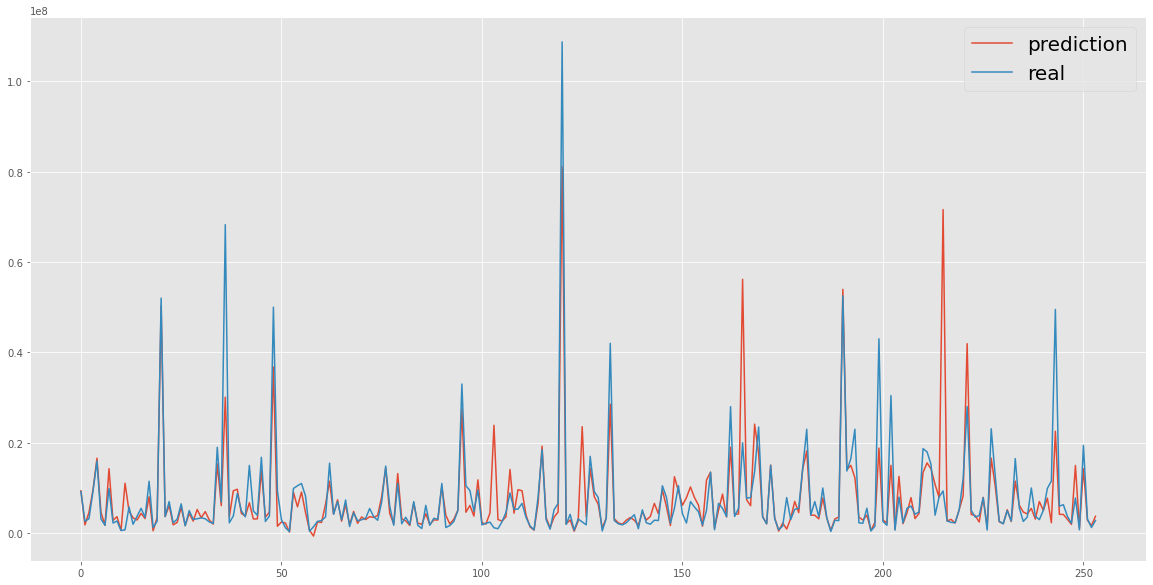

In [45]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.plot(y_hat, label = 'prediction')
plt.plot(val_data_y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

파란선이 실제 target 값, 붉은 선이 우리의 모델이 예측한 값입니다.

### train 셋 + val 셋 100% 활용하는 모델 만들기

이제 검증 셋으로 성능이 유의미한지 확인을 하였다면 데이터를 100% 활용하기 위하여
검증 셋을 포함한 train 셋을 만들어보겠습니다.

In [46]:
train_X = train.drop(['id', 'target'], axis = 1) #training 데이터에서 피쳐 추출
train_y = train.target #training 데이터에서 target 추출

In [47]:
#모델들을 할당할 리스트를 만들어줍니다.
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(ExtraTreesRegressor(n_estimators=110))
models.append(RandomForestRegressor(n_estimators=110))
models.append(GradientBoostingRegressor(learning_rate=0.22, criterion='mae'))

#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
for model in models:
    model.fit(train_X, train_y)

C:\Users\sun\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1630: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


## 예측하기

이제 학습된 모델을 이용하여 주어진 test데이터로 예측을 진행해 보겠습니다.

앞서 train 셋에서 했던 동일한 전처리 과정을 거치되, data leakage가 발생하지 않도록 주의합니다.

In [48]:
check_missing_col(test) # 결측치 확인

test = test.drop('id', axis = 1) #분석에 필요없는 열 삭제

test['brand'] = test['title'].apply(lambda x : x.split(" ")[0])

temp = clean_text(test['paint']) #메소드 적용
test['paint'] = temp
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'blue' if x.find('blue') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'red' if x.find('red') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'green' if x.find('green') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'white' if x.find('white') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('grey') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gery') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'grey' if x.find('gray') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'ash' if x.find('ash') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'brown' if x.find('brown') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('silver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'silver' if x.find('sliver') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'black' if x.find('black') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'gold' if x.find('gold') >= 0 else x)
test['paint'] = test['paint'] = test['paint'].apply(lambda x : 'wine' if x.find('whine') >= 0 else x)

test = label_encoder(test, le)

결측치가 존재하지 않습니다


In [49]:
# 전처리가 완료된 테스트 데이터셋을 통해 본격적으로 학습한 모델로 추론을 시작합니다.
prediction = None

# 학습 된 모델들을 순차적으로 불러옵니다.
for model in models:
    # 각 모델들의 최종 회귀값들을 prediction에 모두 더해줍니다.
    if prediction is None:
        prediction = model.predict(test)
    else:
        prediction += model.predict(test)

# 앙상블에 참여한 모든 모델의 수 만큼 다시 나눠줍니다 (= 평균)
prediction /= len(models)

In [50]:
y_pred = model.predict(test)
y_pred[0:5]

array([13488784.61612922,  6191182.80134975,  5977791.12186718,
        1103495.67885351,  2406585.87023137])

## Dacon 대회에 제출하기 (Submission)

이제 학습한 모델을 사용하여 이 예측 결과를 submit1.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [51]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv('sample_submission.csv')
submission.head()

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


submission을 csv 파일로 저장합니다.
index=False란 추가적인 id를 부여할 필요가 없다는 뜻입니다.
정확한 채점을 위해 꼭 index=False를 넣어주세요.

In [52]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['target'] = y_pred

# 데이터가 잘 들어갔는지 확인합니다.
submission.head()

,id,target
0,0,1.348878e+07
1,1,6.191183e+06
2,2,5.977791e+06
3,3,1.103496e+06
4,4,2.406586e+06


In [53]:
submission.to_csv('submit2.csv', index=False)

이렇게 생성된 submit2.csv 파일을 데이콘 대회 페이지에 업로드 & 제출하여 결과를 확인해보세요!

문제를 해결하기 위한 여러분의 방법을 코드 공유 게시판에 공유해주세요

좋아요와 댓글을 합산하여 가장 높은 점수를 얻으신 분께 데이콘 후드가 제공됩니다!